In [1]:

import numpy as np
import pandas as pd
import re
import unidecode
import string
import nltk
import gensim
import warnings
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from nltk.tokenize import word_tokenize

# Filter specific warning category
warnings.filterwarnings("ignore", category=DeprecationWarning)

nltk.download('stopwords') 
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marjorie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marjorie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
folder = os.getcwd()+'\\RESTAURANTS'
os.chdir(folder)

In [3]:
# import data of different cities in a single dataset.
df = pd.concat([pd.read_csv(file) for file in os.listdir() if '.csv' in file], axis=0)

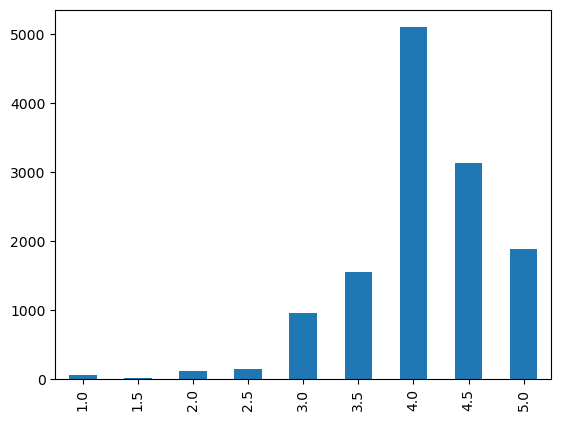

In [4]:
df = df[(df.tripadv_rating.notnull())]
df.tripadv_rating.value_counts().reindex(np.linspace(1,5,9)).plot(kind='bar')
plt.show()

In [5]:
def preprocess_list(x):
 text_list=x.replace("[","").replace("]","").split(", '")
 for index, text in enumerate(text_list):
   text_list[index] = text.replace("'","")
 return text_list

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """Function that cleans the input text:
    - remove links
    - remove special characters
    - remove numbers
    - remove stopwords
    - convert to lowercase
    - remove excessive white spaces
    Arguments:
        text (str): text to clean
        remove_stopwords (bool): whether to remove stopwords
    Returns:
        str: cleaned text
    """
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove numbers and special characters
    #text = re.sub(r"...\S+", "", text)
    # remove stopwords
    if remove_stopwords:
        # 1. create tokens
        tokens = nltk.word_tokenize(text)
        # 2. check if it's a stopword
        tokens = [w.lower().strip() for w in tokens if not w.lower() in stopwords.words("portuguese") and len(w.lower().strip())>2]
        # return a list of cleaned tokens
        return tokens


In [6]:
df['reviews'] = df['reviews'].map(lambda x: preprocess_list(x))
df['price/food/meals/description'] = df['price/food/meals/description'].map(lambda x: preprocess_list(x))
df.reviews.iloc[0]
df['price/food/meals/description'].iloc[1]
df['description'] = df['price/food/meals/description'].map(lambda x: x[1:] if 'R$' in x[0] else x)
df['len'] = df.description.map(lambda x:len(x))
df = df[df.len!=0]
lista= df.description.tolist()

In [7]:
from itertools import chain
flat_list = list(chain(*lista))
if 'R$' in ' '.join(flat_list):
    print(False)
else:
    print(True)

True


In [8]:
df['price'] = df['price/food/meals/description'].map(lambda x: x[0] if  'R$' in x[0] else None)
df['description'] = df['price/food/meals/description'].map(lambda x: x[1:] if 'R$' in x[0] else x)
df['len'] = df.description.map(lambda x:len(x))
df = df[df.len!=0]
df['minimum_price'] = df.price.map(lambda x: x.split(' - ')[0].replace('R$','').strip() if x!=None else x)
df['maximum_price'] = df.price.map(lambda x: x.split(' - ')[1].replace('R$','').strip() if x!=None else x)

In [9]:
data = df.description.tolist()

In [10]:
def treat_process(x):
    datum=re.sub(r'[...,!,:,),(,*0-9]',' ',unidecode.unidecode(' '.join(','.join(x).split(',')).strip().lower()))   
    return ' '.join(list(set(datum.split(' '))-set(stopwords.words("Portuguese"))-set([''])))

In [11]:
df['description'] = df.description.map(lambda x: treat_process(x))
df['reviews'] = df.reviews.map(lambda x: treat_process(x))

In [12]:
df = df[((df.description!='') & (df.description!='...'))]

In [13]:
df['corpus'] = df['description']+df['reviews']

In [14]:
text_data = df.description.tolist()
tag = df.tripadv_rating.tolist()
tagb = df["Unnamed: 0"].tolist()
assert len(tag)==len(text_data)
assert len(tagb)==len(text_data)

In [15]:
dictionary_tag={5:'A', 4.5:'A', 4.0:'B', 3.5:'B',  3.0:'C', 2.5:'C', 2.0:'C', 1.5:'C',1.0:'C',0.5:'C', 0:'C'}

In [16]:
json.dump(df.corpus.tolist(),open('test','w'))

In [17]:
sentences = json.load(open('test','r'))

In [18]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(sentences)]

In [19]:
model = Doc2Vec(min_count=1, vector_size=300, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=1000)

In [20]:
model.save("d2v.model")

In [21]:
model = Doc2Vec.load("d2v.model")

In [22]:
similar_doc = model.dv.most_similar(1,topn=20)

In [23]:
similar_doc

[(7016, 0.42266738414764404),
 (3740, 0.42234933376312256),
 (5956, 0.42091354727745056),
 (4852, 0.3962133228778839),
 (4918, 0.38509654998779297),
 (3931, 0.37584948539733887),
 (4340, 0.37333133816719055),
 (6245, 0.37202149629592896),
 (8384, 0.3664815127849579),
 (477, 0.36486074328422546),
 (8526, 0.36380520462989807),
 (8737, 0.36164000630378723),
 (4557, 0.35680094361305237),
 (2936, 0.35657569766044617),
 (4183, 0.3560754954814911),
 (8021, 0.3549533188343048),
 (4211, 0.35141512751579285),
 (2667, 0.3506387174129486),
 (7352, 0.3500428795814514),
 (4711, 0.34942153096199036)]

In [24]:
tagb[1], tagb[3252], tagb[62],tagb[3255],tagb[7365], tagb[8423]

('Di Vino',
 "Olli's Burger",
 'Pescatore',
 'La Plancha 292',
 'Boteco Português',
 "Carlito's Bar")

In [25]:
df['number_of_reviews']=df['number_of_reviews'].map(lambda x: x.split(' ')[0].replace('.','') if isinstance(x,str) \
                                                    else x).astype(float)

In [26]:
sns.distplot(df.number_of_reviews[df.number_of_reviews<500])

ModuleNotFoundError: No module named 'seaborn'

In [ ]:

def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    keys = model.dv.index_to_key
    vectors = np.asarray([model.dv[keys[key]] for key in keys]) 

    tsne = TSNE(n_components=num_components, random_state=0)
    pca = PCA(n_components=2)
    
    vectors_pca = pca.fit_transform(vectors)
    vectors_tsne = tsne.fit_transform(vectors)

    x_pca = [v[0] for v in vectors_pca]
    y_pca = [v[1] for v in vectors_pca]
    x_tsne = [v[0] for v in vectors_tsne]
    y_tsne = [v[1] for v in vectors_tsne]
    labels = [tagb[key] for key in keys]
    return x_pca, y_pca, x_tsne, y_tsne, labels


In [ ]:
x_pca, y_pca, x_tsne, y_tsne, labels = reduce_dimensions(model)

In [ ]:
plt.scatter(x_pca, y_pca, label = labels)
plt.show()

In [ ]:
plt.scatter(x_tsne, y_tsne, label = labels)
plt.show()